In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 
import re 
import sys
import csv
import math
from distutils.dir_util import copy_tree
from pathlib import Path

import subprocess
import json

import subprocess
import time

# rootDir = os.getcwd()
# rootDir = r'C:\Users\Laxman\Desktop\autoWoodSDA\Auto-WoodSDA'
rootDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/woodSDA/autoWoodSDA_public'


pd.set_option('display.max_colwidth', 100)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Design Module:
The design module designs the building per input specifications and outputs design summary with shear wall schedule for each story.

Note: To remove redundancies, ```design_and_generate_model``` implements design module in its entirety and some aspects of structural module. In particular, it creates the OpenSees models.

Three individual models are created for Modal, Pushover, and Dyanmic analysis. The flags ___generate_static_models___, and ___generate_dynamic_models___ can be used to specify the specific model to be generated whil ___RunPushoverSwitch___ can be used to automatically run the pushover analysis. If pushover analysis is turned on, the static models need to be created. 

In [16]:
from run_designModule import design_and_generate_model
dataDir = os.path.join(rootDir, 'Databases')
baseline_BIM = json.load(open(os.path.join(dataDir, 'Baseline_archetype_info_w_periods.json')))

In [23]:
buildingID = 'MFD6B'

In [17]:
designModule = design_and_generate_model(building_id=buildingID,
                                          baseline_building_info=baseline_BIM,
                                          save_design_csv=False,
                                         generate_static_models=False, 
                                         run_pushover=False,
                                         generate_dynamic_models=False
                                          )

Missing Risk Category detected. Assigned "II" as the default risk category
Missing response modification factor (R) detected. Assigned 6.5 as the default R value
Missing deflection amplification factor (Cd) detected. Assigned 4 as the default Cd value
Missing design importance factor (Ie) detected. Assigned 1.0 as the default Ie value
Successfully generated code-compliant design!!
Model creation for MFD6B took 4.932276010513306 seconds


In [18]:
designModule.final_design

Shear Wall Assembly  ...  OpenSees Tag
swDesign_gridA_wall1 0    Use 1/2in GWB with 5d cooler nails @ 7in o.c. spacing  ...            14
                     1   Use 7/16in WSP on 1 side with 8d nails @ 6o.c. spacing  ...             1
                     2   Use 7/16in WSP on 1 side with 8d nails @ 3o.c. spacing  ...             2
                     3   Use 7/16in WSP on 1 side with 8d nails @ 2o.c. spacing  ...             5
swDesign_gridA_wall2 0    Use 1/2in GWB with 5d cooler nails @ 7in o.c. spacing  ...            14
...                                                                         ...  ...           ...
swDesign_grid7_wall1 3   Use 7/16in WSP on 1 side with 8d nails @ 2o.c. spacing  ...             5
swDesign_grid7_wall2 0    Use 1/2in GWB with 5d cooler nails @ 7in o.c. spacing  ...            14
                     1    Use 3/8in WSP on 1 side with 6d nails @ 6o.c. spacing  ...             3
                     2  Use 15/32in WSP on 1 side with 8d nails @ 4o.c. spacing  ...            12
                     3   Use 7/16in WSP on 1 side with 8d nails @ 2o.c. spacing  ...             5

[120 rows x 7 columns]

## Structural Module

If the OpenSees models have not been generated in the previous step, they are generated as follows:

In [19]:
sys.path.append(os.path.join(rootDir, *['Codes','structuralModule']))
from BuildingModelClass import BuildingModel
from utils_opensees import *

In [21]:
## structural module requires input df
from designModule.check_user_inputs import check_and_complete_inputs
buildingID = 'MFD6B'

df_inputs = pd.read_csv(os.path.join(rootDir, 'Buildings_input_info.csv'))
df_inputs = df_inputs[df_inputs['BuildingID']==buildingID]
df_inputs = check_and_complete_inputs(input_df = df_inputs)
df_inputs.head()

Missing Risk Category detected. Assigned "II" as the default risk category
Missing response modification factor (R) detected. Assigned 6.5 as the default R value
Missing deflection amplification factor (Cd) detected. Assigned 4 as the default Cd value
Missing design importance factor (Ie) detected. Assigned 1.0 as the default Ie value


,BuildingID,Layout Type,SiteID,Latitude,Longitude,Site Class,Risk Category,R,Cd,Ie,Allowable Drift,Design Year,Ss(g),S1(g),wallMaterial,seismicWeight
0,MFD6B,s4_96x48,1,33.9721,-118.42177,D,II,6.5,4.0,1.0,0.02,2020,1.855,0.654,Stucco_GWB,Normal


In [7]:
start = time.time()

InfoDirectory = os.path.join(rootDir, *['BuildingInfo', caseID])
ModelClass = BuildingModel(caseID)
ModelClass.read_in_txt_inputs(caseID, InfoDirectory, df_inputs)

os.chdir(ModelDirectory+'/%s'%caseID)
period = generateModalAnalysisModel(ModelClass.ID, ModelClass, rootDir)
# Turn off RunPushoverSwitch to speed up the model creation 
generatePushoverAnalysisModel(ModelClass.ID, ModelClass, rootDir,
                           GenerateModelSwitch = True, RunPushoverSwitch = True)
generateDynamicAnalysisModel(ModelClass.ID, ModelClass, rootDir, period,
                           GenerateModelSwitch = True)
print(period)

finish = time.time()
print((finish - start)/60, 'Minutes')

[0.47873545671261836, 0.44088576850062644, 0.40483258086087187, 0.17383062505885144]
13.003056426843008 Minutes


In [8]:
# BuildingList = [caseID]

### Implementing a part of damage Module to extract results from nonlinear static analysis

In [22]:
sys.path.append(os.path.join(rootDir, *['Codes', 'damageModule']))

import ExtractPushoverData as epd

#### Eigen Analysis summary

In [24]:
eigenDirectory = os.path.join(rootDir, *['BuildingModels',buildingID,'EigenValueAnalysis','Analysis_Results'])
periods = extractedps.ExtractPeriod(eigenDirectory)
periods

,0,1,2
0,0.478735,0.440886,0.404833


### Nonlinear static pushover curve

In [30]:
PushoverX = epd.pushoverdata(os.path.join(BaseDirectory, 'PushoverAnalysis'),
                             'X', 'roof', SeismicWeight, numFloors)
PushoverResultsX = epd.extractpushoverpoints(PushoverX)

PushoverResultsX = np.append(np.array(PushoverResultsX), PushoverX[1][-1])

PushoverY = epd.pushoverdata(os.path.join(BaseDirectory, 'PushoverAnalysis'),
                             'Z', 'roof', SeismicWeight, numFloors)
PushoverResultsY = epd.extractpushoverpoints(PushoverY)

PushoverResultsY = np.append(np.array(PushoverResultsY), PushoverY[1][-1])

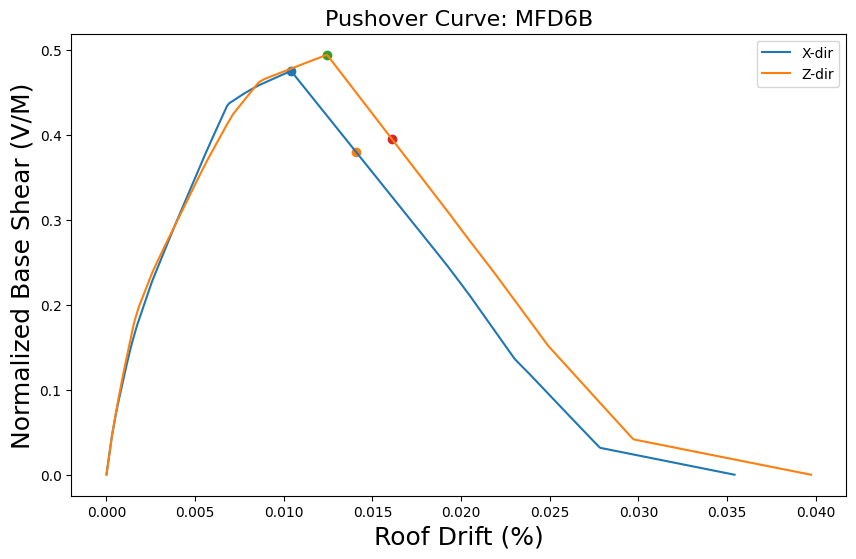

In [33]:
plt.figure(figsize = (10,6))
plt.plot(PushoverX[1],PushoverX[0],label = 'X-dir')
plt.plot(PushoverY[1],PushoverY[0],label = 'Z-dir')

plt.scatter(PushoverResultsX[1],PushoverResultsX[0])
plt.scatter(PushoverResultsX[2], 0.8*PushoverResultsX[0])

plt.scatter(PushoverResultsY[1],PushoverResultsY[0])
plt.scatter(PushoverResultsY[2], 0.8*PushoverResultsY[0])

plt.xlabel('Roof Drift (%)', fontsize=18)
plt.ylabel('Normalized Base Shear (V/M)', fontsize=18)
plt.title(f'Pushover Curve: {buildingID}', fontsize = 16)
plt.legend()
plt.show()


In [34]:
df = pd.DataFrame([PushoverResultsX, PushoverResultsY], 
                  columns = ['Peak Strength', 'Drift at Peak', 'Drift at 80%Peak', 'Max Drift'],
                  index = ['X', 'Y'])
df.head()

,Peak Strength,Drift at Peak,Drift at 80%Peak,Max Drift
X,0.475575,0.010408,0.014069,0.035421
Y,0.494818,0.012431,0.016085,0.039735


The results from nonlinear static analysis looks good. Now, let's go back to the structural module to run nonlinear response history analysis (NLRHA)

### Run dynamic analysis- Structural Module

Files required to run dynamic analysis has been created in the previous step, the following code iteratively runs the dynamic analysis upto the specified number of Ground motions.


In [15]:
### MSA using selected GM records for 5 hazard levels. Location: Boelter Hall
Scale_Sa_GM = '0.403 0.975 1.307 1.676 2.237'
GM_Num = '50 47 47 48 47'

# GM_ID = 1 # GM pair
GM_folder = r'GM_sets/BoelterHall'

Model_Name = buildingID


# start_ID is tarting index which starts from 1 instead of 0
# finish_ID is the total number of GMs in multiple stripe or incremental dynamic analysis
# for eg: if you have 10 hazard levels with 22 GM pairs, finish_id should be 10*22 + 1
start_ID, finish_ID = 1, 3 # for demonstration I'm running dynamic analysis for 2 ground motion pairs
acc_time = 0
start_time = time.time()


## following chucks of codes run dynamic analysis for each ground motion pair iteratively
# Pairing ID == 1 i.e. apply H1 motion in X and H2 motion in Z
for GM_ID in range(start_ID, finish_ID):
    s = time.time()
    SetupDyamaicAnalysis(ModelDirectory, Scale_Sa_GM, GM_Num, GM_ID, GM_folder, Model_Name, 1)
    os.chdir(ModelDirectory)
    r = os.system('OpenSees RunDynamic_Single.tcl')
    f = time.time()
    if not r: 
        print('Hazard Level %i GM Pair %s with Pairing ID %i has finished successfully in %.3fs!'%(int(GM_ID/50)+1, str(GM_ID-int(GM_ID/50)), 1, f-s))
        os.remove('RunDynamic_Single.tcl')
        acc_time += (f-s)
        #print('Estimate remaining time %.3fs!'%(acc_time/(GM_ID - start_ID)*(finish_ID - GM_ID)))
    else: 
        print('GM Pair %s has failed'%str(GM_ID))
        break

# Pairing ID == 2 i.e. apply H2 motion in X and H1 motion in Z
for GM_ID in range(start_ID, finish_ID):
    s = time.time()
    SetupDyamaicAnalysis(ModelDirectory, Scale_Sa_GM, GM_Num, GM_ID, GM_folder, Model_Name, 2)
    os.chdir(ModelDirectory)
    r = os.system('OpenSees RunDynamic_Single.tcl')
    f = time.time()
    if not r: 
#         print('Hazard Level %i GM Pair %s with Pairing ID %i has finished successfully in %.3fs!'%(int(GM_ID/22)+1, str(GM_ID-int(GM_ID/22)), 2, f-s))
        os.remove('RunDynamic_Single.tcl')
        acc_time += (f-s)
        #print('Estimate remaining time %.3fs!'%(acc_time/(GM_ID - start_ID)*(finish_ID - GM_ID)))
    else: 
        print('GM Pair %s has failed'%str(GM_ID))
        break

finish_time = time.time()
print('The total runtime is %.3f minutes' %(int(finish_time-start_time)/60))

Hazard Level 1 GM Pair 1 with Pairing ID 1 has finished successfully in 25.873s!
Hazard Level 1 GM Pair 2 with Pairing ID 1 has finished successfully in 64.328s!
The total runtime is 2.500 minutes


## Damage Module

Execute the following lines of only after all the dynamic analyses have been completed for all the hazard levels

In [16]:
# import ExtractMaxEDP as extractedps

# NumGM = np.array([50, 47, 47, 48, 47])

# CollapseCriteria = 0.1
# DemolitionCriteria = 0.01

# HazardLevel = np.array([0.403, 0.975, 1.307, 1.676, 2.237])

# dynamicDirectory = os.path.join(cwd, *['BuildingModels',buildingID,'DynamicAnalysis'])

# sdr = extractedps.ExtractSDR(dynamicDirectory, HazardLevel, NumGM, numFloors)
# rdr = extractedps.ExtractRDR(dynamicDirectory, HazardLevel, NumGM, NumStory)
# gmDirectory = r'C:\Users\Laxman\Desktop\Python Tool\BuildingModels\GM_sets\BoelterHall'
# PGA = extractedps.ExtractPGA(gmDirectory, HazardLevel, NumGM)
# pfa = extractedps.ExtractPFA(dynamicDirectory, HazardLevel, NumGM, NumStory, PGA, g = 386.4)


#### Building-level fragilities such as collapse, and demolition fragilities

Please refer to ```Plot_Results.ipynb``` file located in __postProcessing__ folder for code to fit the fragility

Since running NLRHA takes a long time, here, I am importing the processed EDP data for the example building (MFD6B) presented in the paper. 

In [37]:
resultDirectory = os.path.join(rootDir, 'Results')
edp_data_dir = os.path.join(resultDirectory, buildingID, 'EDP_data')
pfa = pd.read_csv(os.path.join(edp_data_dir, 'PFA.csv'), header=None)
sdr = pd.read_csv(os.path.join(edp_data_dir,'SDR.csv'), header=None)
rdr = pd.read_csv(os.path.join(edp_data_dir,'RDR.csv'), header=None)

## Loss Module

The loss module implements PELICUN to assess economic loss per FEMA P-58 methodology. It also implements MATLAB-based beta ATC-138 Functional Recovery methodology to assess recovery times (reoccupancy, functional recovery, etc)

### Implementing Pelicun

The ```driverPelicun_E2E.py``` file automatically generates all the input files required by Pelicun and runs Pelicun to generate the Monte Carlo loss samples. It also formats the component-level damage samples in the ATC-138 friendly format. The input files required by ATC-138 are also created here.

In [39]:
from lossModule.driverPelicun_E2E import main

In [40]:
N_story = int(df_inputs['Layout Type'].values[0][1])
building_length = float(df_inputs['Layout Type'].values[0].split('_')[1].split('x')[0])
building_width = float(df_inputs['Layout Type'].values[0].split('_')[1].split('x')[1])


In [41]:
main(buildingID=buildingID,
    num_story = N_story,
    archetype_length= building_length, 
    archetype_width= building_width
    )

Initiating PELICUN Loss of MFD6B...
2024-05-31T19:33:36Z 0 realizations removed from the demand input because they exceed the collapse limit. The remaining sample size: 44
Finished PELICUN Loss of MFD6B @ IL-1 
2024-05-31T19:33:47Z 0 realizations removed from the demand input because they exceed the collapse limit. The remaining sample size: 44
Finished PELICUN Loss of MFD6B @ IL-2 
2024-05-31T19:34:00Z 0 realizations removed from the demand input because they exceed the collapse limit. The remaining sample size: 44
Finished PELICUN Loss of MFD6B @ IL-3 
2024-05-31T19:34:14Z 0 realizations removed from the demand input because they exceed the collapse limit. The remaining sample size: 44
Finished PELICUN Loss of MFD6B @ IL-4 
2024-05-31T19:34:30Z 0 realizations removed from the demand input because they exceed the collapse limit. The remaining sample size: 44
Finished PELICUN Loss of MFD6B @ IL-5 
2024-05-31T19:34:46Z 0 realizations removed from the demand input because they exceed the

### Implementing beta ATC-138 


The ATC-138 methodology is a MATLAB-based tool. There are various ways to run Matlab code via Python. In this study, I use Matlab Engine API for Python to run the Matlab code. The engine API is availale as a Python package.

In [ ]:
import matlab.engine
from lossModule.driverATC138_E2E import main_hazard_agnostic

In [ ]:
main_hazard_agnostic(buildingID)

__Note:__

When I was developing WoodSDA, MATLAB API for Python was not natively supported on my laptop (Mac with Arm64 archetecture) which is why I am not able to demonstrate that the code works in this notebook. For my work, I used HPC cluster (Hoffman2) to run the ATC-138 code and I can confirm that the code in the above two cells are functional. Please refer to ```postProcessing/Plot_Results.ipynb``` for the reoccupancy and functional recovery time curves.